# Lab 2: Dimensionality Reduction

In this lab, we will look into the problems of dimensionality reduction through Principal Component Analysis (PCA), Singular Value Decomposition (SVD) and Multidimensional Scaling (MDS). After the lab, you should be familiar with these standard dimensionionality reduction techniques and be able to understand how they work.

### Introduction
In Data Mining and Machine Learning, data is typically represented in a tabular form, where rows correspond to examples (also known as instances) and columns correspond to attributes (also known as features). Take, for example, the following data matrix.

In [1]:
import numpy as np
import pandas as pd

content = np.array([[22, 1.83, 80, 9000, 2],[17, 1.90, 88, 2000, 0],[24, 1.71, 59, 18000, 1]])

df = pd.DataFrame(content, index=['Giannis', 'Giorgos', 'Maria'], columns=['Age', 'Height', 'Weight', 'Income', 'Siblings'])
df

,Age,Height,Weight,Income,Siblings
Giannis,22.0,1.83,80.0,9000.0,2.0
Giorgos,17.0,1.90,88.0,2000.0,0.0
Maria,24.0,1.71,59.0,18000.0,1.0


This data matrix consists of $3$ examples (its $3$ rows) and of $5$ attributes (its $5$ columns). Each example is described by its values for the $5$ attributes.

In this toy example, the number of attibutes is very small. However, the dimensionality of real-world data is several orders of magnitude higher. For example, the dimensionality of a $640 \times 480$ image is equal to $307,200$ assuming that each pixel of the image is an attribute. The same problem applies to the case of DNA microarrays, where features correspond to the expression levels of the genes, and there are many thousands of such expression levels.

When we have many features, we may have a difficulty using them all. This is mainly because
<ul>
  <li>Learning would be very slow</li>
  <li>It is very likely to overfit the data (giving poor generalization)</li>
</ul>

Instead, we would like to preprocess the data to obtain the most important features. The dimensionality reduction techniques transform the input data from a high-dimensional space into a space of fewer dimensions. Assuming that we have a set of high dimensional data points $\mathcal{X} = (x_1, x_2, \ldots, x_N), x_i \in \mathbb{R}^d$, the dimensionality reduction techniques seek to find a representation of the $N$ data points into a lower dimensional space $\mathbb{R}^k$ where $k \ll d$, keeping as much of the variance and/or the pairwise distances as possible.

### Principal Component Analysis (PCA)
Principal Component Analysis (PCA) is a standard dimensionality reduction technique. We will create a toy dataset in order to illustrate how PCA works. The dataset will consist of $200$ $20$-dimensional points ($N = 200$, $d = 20$). There will be two classes ($1$ and $-1$). Half of the points will belong to the first class, and the other half to the second class.

More specifically, the first two dimensions for each point will be drawn from a Gaussian distribution. For points belonging to class $1$, use for both dimensions a Gaussian distribution with mean $1$ and standard deviation $0.7$. Conversely, for points belonging to class $-1$, use for both dimensions a Gaussian distribution with mean $-1$ and standard deviation $0.7$. To generate these values make use of the `randn` function (https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.randn.html) that returns a sample from the 'standard normal' distribution as follows: $$sigma * np.random.randn(...) + mu$$

After generating the first two dimensions for all points, plot them in a 2d plane using `scatter` (http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter). Set the color of points belonging to class $1$ to blue and the color of the rest of the points to red.

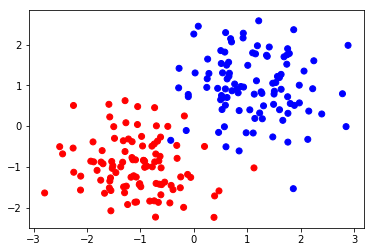

In [2]:
N = 200 # number of points
d = 20 # number of dimensions

X = np.zeros((N,d))
labels = np.zeros(N)

mu = np.array([1, 1]) # mean
sigma = 0.7 # standard deviation

for i in range(int(N/2)):
    X[i,:2] = sigma * np.random.randn(2) + mu
    labels[i] = 1

mu = np.array([-1, -1]) # mean
sigma = 0.7 # standard deviation

for i in range(int(N/2), N):
    X[i,:2] = sigma * np.random.randn(2) + mu
    labels[i] = -1
    
%matplotlib inline
import matplotlib.pyplot as plt

colors = []

for i in range(N):
    if labels[i] == 1:
        colors.append('blue')
    else:
        colors.append('red')
        
plt.scatter(X[:,0], X[:,1], c=colors)

Generate the remaining $d-2$ features for each point using Gaussian noise as follows: $$X_{noise} = 0.01 * np.random.randn(...)$$

In [3]:
sigma_noise = 0.01
X_noise = sigma_noise * np.random.randn(N, d-2)
X[:,2:] = X_noise

Compute the principal components of the dataset using the function `PCA` provided by `scikit-learn` (http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). Set the number of principal components equal to $k = 3$.

In [4]:
from sklearn.decomposition import PCA
n_components = 3
pca = PCA(n_components)
X_reduced = pca.fit_transform(X)

Given the projected data, plot it in one dimension (as points in a line), in two dimensions and in three dimensions using again `scatter`.

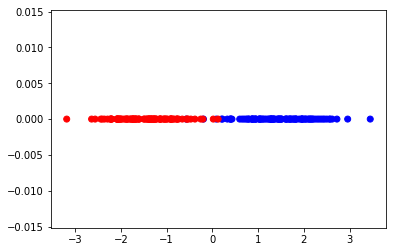

In [5]:
plt.scatter(X_reduced[:,0], np.zeros(N), c=colors)

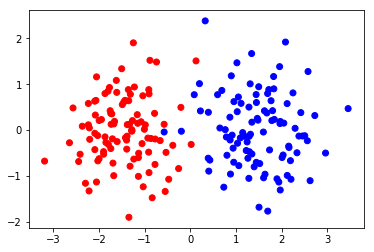

In [6]:
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=colors)

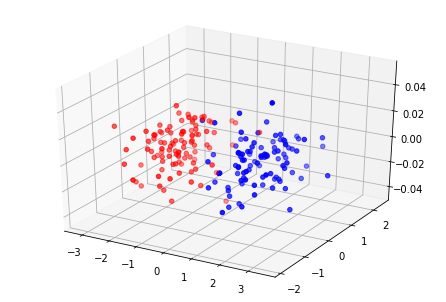

In [7]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(X_reduced[:,0], X_reduced[:,1], X_reduced[:,2], c=colors)

How would you interpret the meaning of the resulting plots? What is the effective dimensionality of this dataset?

---

As you learned in the dimensionality reduction lecture, PCA occurs as follows:
* Subtract mean from data (center $\mathbf{X}$): $\mathbf{X}_{c} = \mathbf{X} - \mathbf{M}$
* Construct the $d \times d$ covariance matrix: $\mathbf{C} = \frac{1}{N-1}\mathbf{X}_{c}^T \mathbf{X}_{c}$
    * $\mathbf{C}_{ii}$ (diagonal) is the variance of variable $i$
    * $\mathbf{C}_{ij}$ (off diagonal) is the covariance between variables $i$ and $j$
* Compute the eigenvalues and eigenvectors of the covariance matrix $\mathbf{C}$
* Keep the $k$ eigenvectors $\mathbf{U}_{:k}$ corresponding to the $k$ largest eigenvalues (principal components)
* Project the inputs into the space spanned by the principal components: $\mathbf{X}_{reduced} = \mathbf{X}_{c} \mathbf{U}_{:k}$

Write a function that takes as input a data matrix and an integer $k$, performs PCA and returns the projected data matrix. Follow the steps given above.

In [8]:
def my_pca(X, k):
    mean = X.mean(axis=0)
    
    centered = X - mean
    
    covmat = np.cov(centered.T)
    #covmat = np.dot(centered.T,centered)/199
    
    evals,evecs = np.linalg.eig(covmat)
    # Sort the eigenvectors by decreasing eigenvalues
    indices = evals.argsort()[::-1]
    evals = evals[indices]
    evecs = evecs[:,indices]

    X_reduced = np.dot(centered, evecs[:,:k])
    
    return X_reduced, evals

Perform PCA on the dataset you created above using your PCA function for k=3.

In [9]:
X_reduced, evals = my_pca(X, 3)

Given the new projection matrix, show the same three plots as above.

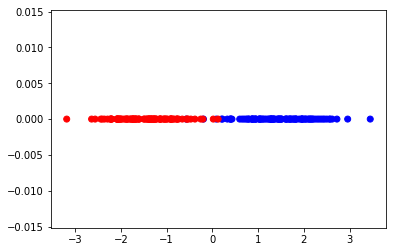

In [10]:
plt.scatter(X_reduced[:,0], np.zeros(N), c=colors)

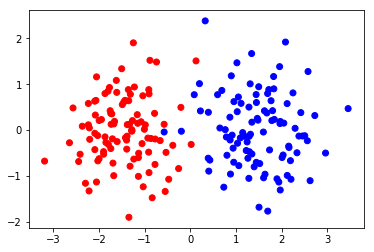

In [11]:
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=colors)

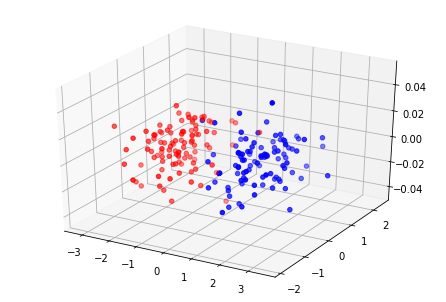

In [12]:
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(X_reduced[:,0], X_reduced[:,1], X_reduced[:,2], c=colors)

Are the plots the same as above. What do you observe?

---

Visualize the first $k = 10$ eigenvalues of the covariance matrix using `scatter`.

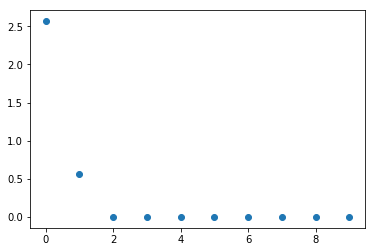

In [13]:
plt.scatter(np.arange(10), evals[:10])

What do you observe? Can you infer the effective dimensionality of the dataset from this plot?

---

We will next employ the famous Iris dataset (https://en.wikipedia.org/wiki/Iris_flower_data_set) that is available from `scikit-learn` (http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html). The Iris dataset contains measurements for $150$ iris flowers from three different species.

The three classes in the Iris dataset are:
1. Setosa ($50$ instances)
2. Versicolor ($50$ instances)
3. Virginica ($50$ instances)

Each instance is described by $4$ features (Sepal Length, Sepal Width, Petal Length and Petal Width).

Your first task is to load the dataset and the class labels. Follow the link given above.

In [14]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target

N = X.shape[0]
d = X.shape[1]

Perform PCA on the Iris dataset and plot the $150$ instances in three dimensions using `scatter`.

In [15]:
n_components=3
pca = PCA(n_components)
X_reduced = pca.fit_transform(X)

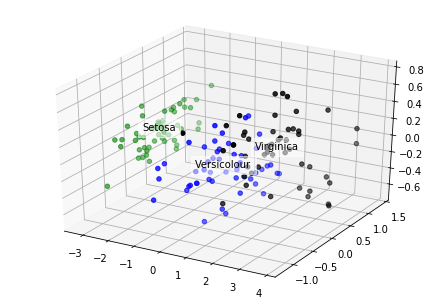

In [16]:
fig = plt.figure()
ax = Axes3D(fig)

for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
    ax.text3D(X_reduced[y == label, 0].mean(),
              X_reduced[y == label, 1].mean(),
              X_reduced[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))

colors = []
for i in range(N):
    if y[i] == 0:
        colors.append('green')
    elif y[i] == 1:
        colors.append('blue')
    else:
        colors.append('black')
    
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=colors)

### Singular Value Decomposition (SVD) 
The next dimensionality reduction technique that we will study is the Singular Value Decomposition (SVD). In fact, SVD is closely related to PCA. We will employ SVD to compute the so-called eigenfaces, which provide an efficient representation of facial images in face recognition.

Let $\mathbf{X}$ be a $n \times d$ matrix, $\mathbf{X} \in \mathbb{R}^{n \times d}$. We are interested in factorizing the matrix $\mathbf{X}$ introducing a matrix $\mathbf{U} \in \mathbb{R}^{n \times n}$, a matrix $\mathbf{\Sigma} \in \mathbb{R}^{n \times d}$ and a matrix $\mathbf{V} \in \mathbb{R}^{d \times d}$.

To factorize the matrix, we will employ the Singular Valued Decomposition (SVD). The SVD of matrix  $\mathbf{X}$ is defined as: $$\mathbf{X} = \mathbf{U} \mathbf{\Sigma} \mathbf{V^T}$$ where
<ul>
  <li> $\mathbf{U}: n \times n$  matrix has as columns the eigenvectors of $\mathbf{X} \mathbf{X^T}$ </li>
  <li> $\mathbf{\Sigma}: n \times d$ is a diagonal matrix with the singular values of $\mathbf{X}$ in the diagonal (= square roots of $\mathbf{X} \mathbf{X^T}$ eigenvalues) </li>
  <li> $\mathbf{V}: d \times d$  matrix has as columns the eigenvectors of $\mathbf{X^T} \mathbf{X}$ </li>
</ul>

We will now give an example of SVD.

**Example**

In [17]:
X = np.array([[1,2,5,3,99],[3,2,4,13,21],[0,8,2,34,4]])

U,S,VT = np.linalg.svd(X)

print ('U:\n', U)
print ('S:\n', S)
print ('VT:\n', VT)
#print ('USVT:\n', np.dot(np.dot(U,np.diag(S)), VT))

U:
 [[-0.97334037  0.13724854  0.18376986]
 [-0.2187029  -0.31390847 -0.92392127]
 [-0.06911993 -0.93948087  0.33555644]]
S:
 [101.78004546  36.70449974   3.54993597]
VT:
 [[-0.01600951 -0.0288568  -0.05776921 -0.07971343 -0.99459513]
 [-0.02191766 -0.21439243 -0.06670443 -0.9702193   0.08820729]
 [-0.72902553  0.33920294 -0.59317208 -0.01429543  0.0374923 ]
 [-0.21959504 -0.91324886 -0.25612531  0.22680353  0.02673039]
 [-0.64773691 -0.06419539  0.75812924 -0.02600142 -0.02966176]]


Reconstruct X:

In [19]:
# create N x d Sigma matrix
Sigma = np.zeros((X.shape[0], X.shape[1]))
# populate Sigma with d x d diagonal matrix
k = min(X.shape[0], X.shape[1])
Sigma[:k, :k] = np.diag(S)
print('Sigma =\n', Sigma)
# reconstruct matrix
B = U.dot(Sigma).dot(VT)
print('Initial Matrix :\n', X)
print('Reconstructed Matrix from SVD :\n',  np.around(B, decimals=1))

Sigma =
 [[101.78004546   0.           0.           0.           0.        ]
 [  0.          36.70449974   0.           0.           0.        ]
 [  0.           0.           3.54993597   0.           0.        ]]
Initial Matrix :
 [[ 1  2  5  3 99]
 [ 3  2  4 13 21]
 [ 0  8  2 34  4]]
Reconstructed Matrix from SVD :
 [[ 1.  2.  5.  3. 99.]
 [ 3.  2.  4. 13. 21.]
 [-0.  8.  2. 34.  4.]]


**Dimensionality Reduction with SVD**

We can use SVD to calculate an approximation $\mathbf{\tilde{X}}$ of $\mathbf{X}$ using $k$ dimensions instead of the original $d$, $k \ll d$. The approximation is given by: $$\mathbf{\tilde{X}}_{n \times d} = \mathbf{U}_{n \times k} \mathbf{\Sigma}_{k \times k} \mathbf{V}^T_{k \times d}$$ 


The matrices $\mathbf{U}$, $\mathbf{\Sigma}$ and $\mathbf{V}$ should then verify that $\mathbf{X} \approx \mathbf{U}_{n \times k} \mathbf{\Sigma}_{k \times k} \mathbf{V}_{k \times d}^\top = \mathbf{\tilde{X}}_{n \times d}$

For example, the second order approximation of $\mathbf{X}$ is:

In [23]:
k = 2
print ('X:\n', X)
print('USV:\n', np.around(np.dot(np.dot(U[:,:k],np.diag(S)[:k,:k]),VT[:k,:]), decimals=2))
#or
print('USV:\n', np.around(U[:,:k].dot(np.diag(S)[:k,:k]).dot(VT[:k,:]), decimals=2))

X:
 [[ 1  2  5  3 99]
 [ 3  2  4 13 21]
 [ 0  8  2 34  4]]
USV:
 [[ 1.48  1.78  5.39  3.01 98.98]
 [ 0.61  3.11  2.05 12.95 21.12]
 [ 0.87  7.6   2.71 34.02  3.96]]
USV:
 [[ 1.48  1.78  5.39  3.01 98.98]
 [ 0.61  3.11  2.05 12.95 21.12]
 [ 0.87  7.6   2.71 34.02  3.96]]


For this part of the lab, we will be working with the Olivetti faces dataset. The Olivetti faces dataset contains 
$10$ different images for each of $40$ distinct subjects ($400$ images in total). The dataset can be downloaded from AT&T using `scikit-learn` (http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html). Use the following code to load the dataset.

In [24]:
from sklearn.datasets import fetch_olivetti_faces

dataset = fetch_olivetti_faces(shuffle=True)
X = dataset.data
N, d = X.shape
print(N, d)
print('Number of classes:', len(set(dataset.target)))

400 4096
Number of classes: 40


Each row of the data matrix corresponds to an image. The dimensionality of each image is $64 \times 64$. Hence, the number of columns of the data matrix is $64 \times 64 = 4096$. 

We next show you how to plot the first image of the dataset.

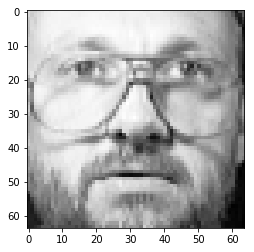

In [25]:
import matplotlib.cm as cm
plt.imshow(X[0, :].reshape(64,64), cmap = cm.Greys_r)

In the problem of human face recognition, eigenfaces is the name given to the principal components of a distribution of faces, or equivalently, the eigenvectors of the covariance matrix of the set of face images.

Your next task is to show the first ten eigenfaces of the Olivetti faces dataset. To compute the eigenfaces, you will perform SVD on the data matrix. Do not forget to center the data matrix.

It is known that matrix $\mathbf{V}$ contains the eigenvectors of the covariance matrix since: $$\mathbf{C} = \frac{1}{N-1}\mathbf{X}^\top \mathbf{X}$$ and $$\mathbf{X}^\top \mathbf{X} = (\mathbf{U}\mathbf{\Sigma}\mathbf{V}^\top)^\top \mathbf{U}\mathbf{\Sigma}\mathbf{V}^\top = \mathbf{V}\mathbf{\Sigma}^2\mathbf{V}^\top$$
Hence, the columns of $\mathbf{V}$ correspond to the eigenfaces.

In [26]:
mean = X.mean(axis=0)
X = X - mean

U,s,VT = np.linalg.svd(X) # svd decomposition
print(VT.shape)

(4096, 4096)


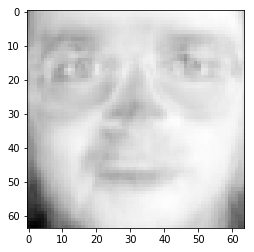

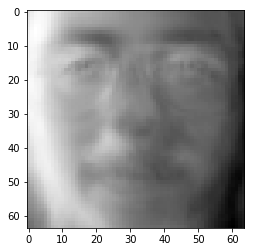

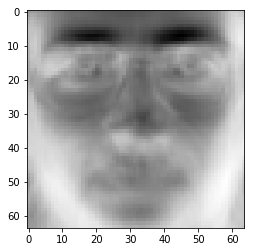

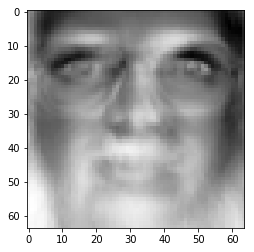

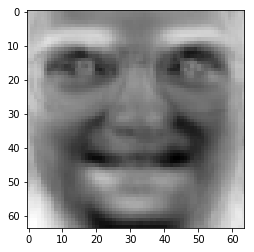

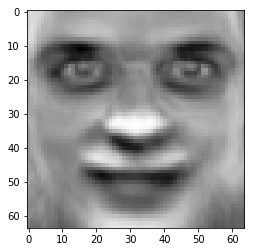

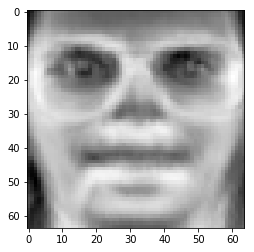

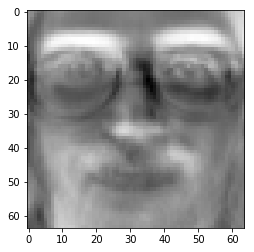

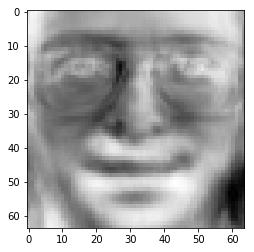

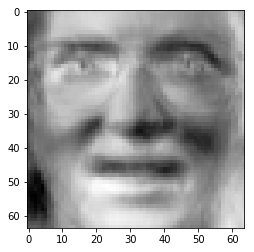

In [27]:
# Print first 10 eigenfaces
for i in range(10):
    plt.imshow(VT[i, :].reshape(64,64), cmap = cm.Greys_r)
    plt.show()

The eigenfaces may be considered as a set of features which characterize the global variation among face images. Then each face image is approximated using a subset of the eigenfaces, those corresponding to the largest eigenvalues. These features account for the most variance in the training set. 

---

The next task is to compute the approximation error for different values of the parameter $k$. Specifically, for values of $k$ from $1$ up to $k = 200$, you will compute the Frobenius norm of the approximation error between the original and the approximation matrix, $err = || \mathbf{X} - \mathbf{\tilde{X}} ||_F$. Having computed these errors, plot them in a 2d plane using `scatter` where the x-axis corresponds to $k$ and the y-axis to the approximation errors.

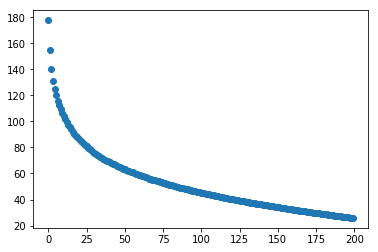

In [28]:
# Computes low rank approximation error for k between 1 and 200
approximationError = np.zeros((200,2))
for k in range(0,200):
    #Xk = np.dot(np.dot(U[:,:k],np.diag(s)[:k,:k]),VT[:k,:])
    Xk = U[:,:k].dot(np.diag(s)[:k,:k]).dot(VT[:k,:])
    approximationError[k,0] = k
    approximationError[k,1] = np.linalg.norm(X-Xk)

# Plots approximation error	
plt.plot(approximationError[:,0], approximationError[:,1],'o')

What do you observe?

### Multidimensional Scaling (MDS)

In some case, we can only measure the distance between instances. MDS places each instance (point) in a low dimensional space such that the distances between them are preserved as well as possible.

As you learned in the dimensionality reduction lecture, MDS occurs as follows:
* Compute matrix $\mathbf{J} = \mathbf{I}-\frac{1}{N}$ where $\mathbf{I}$ is the $N \times N$ identity matrix
* If $\mathbf{D}$ is the distance matrix, compute matrix $\mathbf{B} = -\frac{1}{2}\mathbf{J}\mathbf{D}\mathbf{J}^\top$
* Perform SVD (or eigenvalue decomposition) on matrix $\mathbf{B}$, i.e., $\mathbf{B} = \mathbf{U}\mathbf{\Sigma}\mathbf{V}^\top$
* New data representation: $\mathbf{X}_{n\times k} = \mathbf{U}_{n \times k} \mathbf{\Sigma}_{k \times k}^{\frac{1}{2}}$

You are given a file ('distanceMatrix.csv') containing pairwise distances between different cities in the United States. Run the following code to load the pairwise distances into a matrix $\mathbf{D}$.

In [29]:
D = np.loadtxt('distanceMatrix.csv', delimiter=',')
cities = ['Atl','Chi','Den','Hou','LA','Mia','NYC','SF','Sea','WDC']

See D in dataframe format:

In [30]:
pd.DataFrame(D, index=cities, columns=cities)

,Atl,Chi,Den,Hou,LA,Mia,NYC,SF,Sea,WDC
Atl,0.0,587.0,1212.0,701.0,1936.0,604.0,748.0,2139.0,2182.0,543.0
Chi,587.0,0.0,920.0,940.0,1745.0,1188.0,713.0,1858.0,1737.0,597.0
Den,1212.0,920.0,0.0,879.0,831.0,1726.0,1631.0,949.0,1021.0,1494.0
Hou,701.0,940.0,879.0,0.0,1374.0,968.0,1420.0,1645.0,1891.0,1220.0
LA,1936.0,1745.0,831.0,1374.0,0.0,2339.0,2451.0,347.0,959.0,2300.0
Mia,604.0,1188.0,1726.0,968.0,2339.0,0.0,1092.0,2594.0,2734.0,923.0
NYC,748.0,713.0,1631.0,1420.0,2451.0,1092.0,0.0,2571.0,2408.0,205.0
SF,2139.0,1858.0,949.0,1645.0,347.0,2594.0,2571.0,0.0,678.0,2442.0
Sea,2182.0,1737.0,1021.0,1891.0,959.0,2734.0,2408.0,678.0,0.0,2329.0
WDC,543.0,597.0,1494.0,1220.0,2300.0,923.0,205.0,2442.0,2329.0,0.0


Your next objective is to plot the cities on a 2d plane. Write a function that takes as input a distance matrix and an integer $k$, performs MDS and returns the new data representations. Follow the steps given above. Run your function for the matrix $\mathbf{D}$ and for $k = 2$, and plot the cities on a 2d plane based on their new representations.

[[-2.60587613e-01  1.62375629e-01  3.68444253e-02  1.00323634e-01
  -2.16064363e-01  3.77738555e-01  7.53960704e-01 -3.27976230e-02
  -1.88157529e-01  3.16227766e-01]
 [-1.58253171e-01 -2.15485466e-01  4.41209977e-01 -2.51737977e-03
  -7.48028634e-02  6.16465905e-01 -4.97564400e-01 -1.88528022e-02
  -1.72605446e-02  3.16227766e-01]
 [ 1.79486736e-01  5.33801456e-02  5.35949354e-01  5.72363256e-03
   6.85776846e-01 -2.26459389e-01  2.07758413e-01  1.13428632e-01
   7.56645822e-03  3.16227766e-01]
 [-5.79015120e-02  5.16449494e-01  3.25610890e-01  3.36608781e-02
  -5.24065209e-01 -4.52063845e-01 -1.99953905e-01  5.74254566e-02
   2.20571687e-02  3.16227766e-01]
 [ 4.07822526e-01  1.66480570e-01 -1.80474443e-01 -5.00181979e-01
   2.35551652e-02  9.23736581e-02 -2.26478832e-02 -6.43014693e-01
  -1.19754057e-02  3.16227766e-01]
 [-3.14708686e-01  4.49341136e-01 -5.00173592e-01  3.09237232e-01
   4.05040657e-01  9.50343684e-02 -2.82619672e-01  1.02862904e-02
   1.34367717e-02  3.16227766e-01

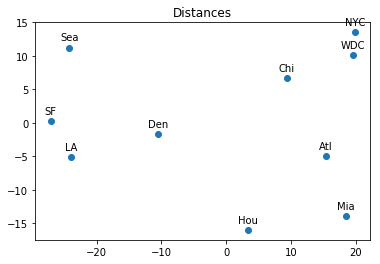

In [31]:
nCities = D.shape[0]

k = 3 # e.g. we want to keep 2 dimensions

J = np.eye(nCities) - (1.0/nCities)

# Compute matrix B
B = -(1.0/2) * np.dot(J, np.dot(D,J.T))
# B = -(1.0/2) * J.dot(D).dot(J.T)

# SVD decomposition of B        
U,S,V = np.linalg.svd(B)
print(U)
# Calculate new data
X = np.dot(U[:,:k],np.sqrt(np.diag(S)[:k,:k]))

# Plot distances in two dimensions
plt.title('Distances')
plt.plot(-X[:,0], -X[:,1],'o')
for i in range(len(cities)):
    plt.text(-X[i,0], -X[i,1]+1.5, cities[i], color='k', ha='center', va='center')

Comment what you observe.